In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sb

In [2]:
class ModifiedLabelEncoder(LabelEncoder):

    def fit_transform(self, y, *args, **kwargs):
        return super().fit_transform(y).reshape(-1, 1)

    def transform(self, y, *args, **kwargs):
        return super().transform(y).reshape(-1, 1)

In [3]:
%matplotlib inline

In [4]:
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
                'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
                'class']
columns_num = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
columns_cat = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
columns_corr_cat = ['marital-status', 'relationship', 'sex']
len(columns_num), len(columns_cat), len(column_names), len(columns_num) + len(columns_cat) 

(6, 8, 15, 14)

In [5]:
def load_data(directory, file_name, names=None, header=None, skiprows=0):
    return pd.read_csv(os.path.join(directory, file_name), names=names, header=header, skiprows=skiprows)

In [6]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [7]:
base_directory = '~/Downloads/tmp/income_prediction'

In [8]:
base_directory

'~/Downloads/tmp/income_prediction'

In [9]:
adult_data_df = load_data(base_directory, 'adult.data', column_names, None, 0)

In [10]:
class_enc = LabelEncoder()
class_tr = class_enc.fit_transform(adult_data_df['class'])
print(dict(zip(class_enc.classes_, class_enc.transform(class_enc.classes_))))


df1 = pd.DataFrame()
df1['class'] = class_tr
for c in columns_num:
    df1[c] = LabelEncoder().fit_transform(adult_data_df[c])
df1.corr()

{' <=50K': 0, ' >50K': 1}


,class,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
class,1.000000,0.234134,-0.010549,0.335154,0.340016,0.162514,0.232393
age,0.234134,1.000000,-0.078463,0.036548,0.125916,0.065058,0.069123
fnlwgt,-0.010549,-0.078463,1.000000,-0.042849,-0.004592,-0.009903,-0.019167
education-num,0.335154,0.036548,-0.042849,1.000000,0.154410,0.084166,0.150094
capital-gain,0.340016,0.125916,-0.004592,0.154410,1.000000,-0.056970,0.101365
capital-loss,0.162514,0.065058,-0.009903,0.084166,-0.056970,1.000000,0.058826
hours-per-week,0.232393,0.069123,-0.019167,0.150094,0.101365,0.058826,1.000000


In [11]:
adult_data_df.corr()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
age,1.000000,-0.076646,0.036527,0.077674,0.057775,0.068756
fnlwgt,-0.076646,1.000000,-0.043195,0.000432,-0.010252,-0.018768
education-num,0.036527,-0.043195,1.000000,0.122630,0.079923,0.148123
capital-gain,0.077674,0.000432,0.122630,1.000000,-0.031615,0.078409
capital-loss,0.057775,-0.010252,0.079923,-0.031615,1.000000,0.054256
hours-per-week,0.068756,-0.018768,0.148123,0.078409,0.054256,1.000000


<AxesSubplot:>

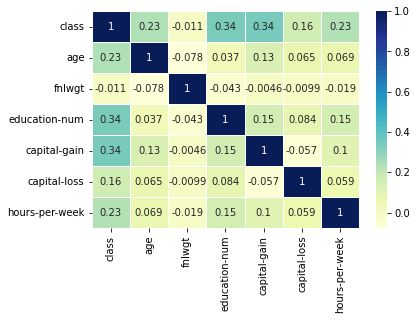

In [12]:
import seaborn as sb
sb.heatmap(df1.corr(), cmap="YlGnBu", annot=True, linewidths=1, )

In [13]:
adult_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  class           32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


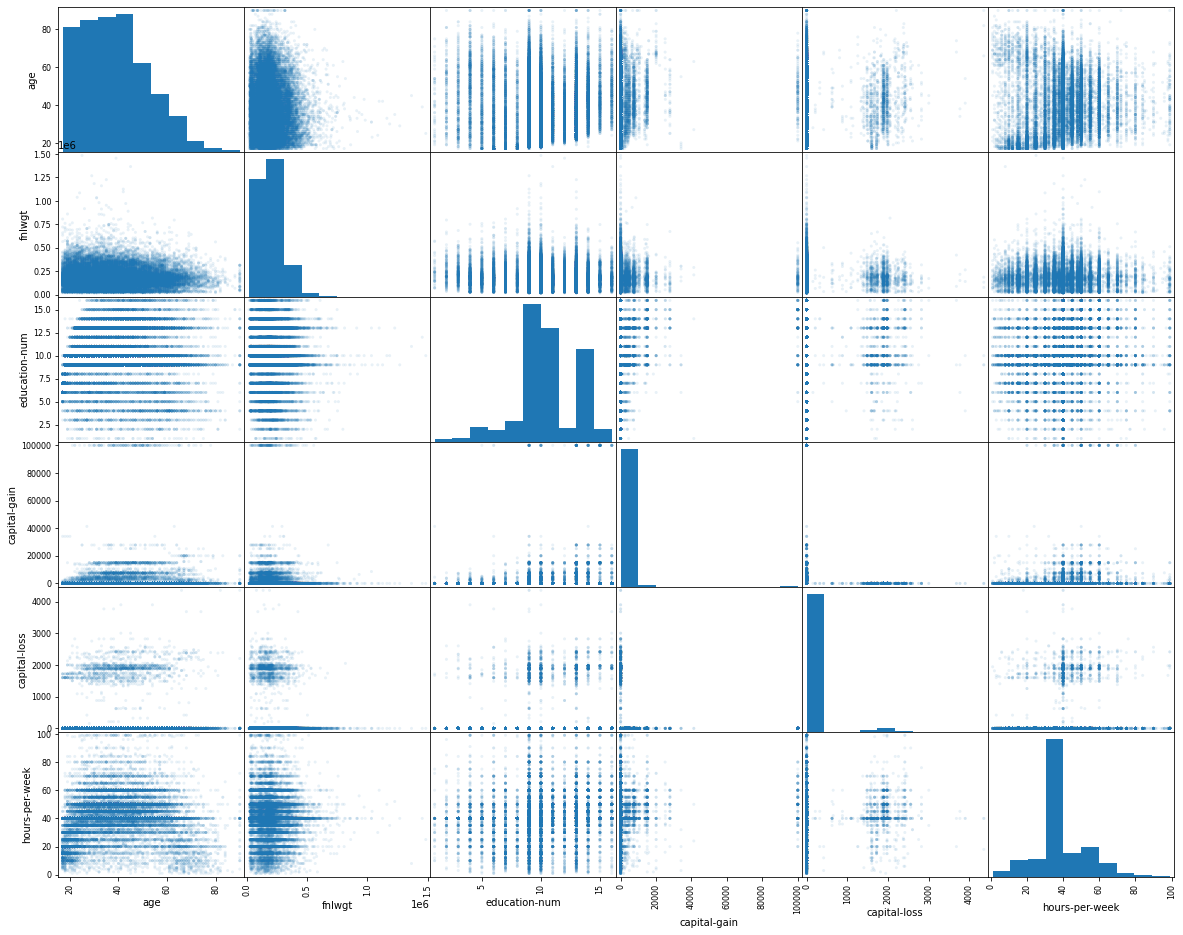

In [14]:
scatter_plot = scatter_matrix(adult_data_df[columns_num], figsize=(20, 16), alpha=0.1)

In [15]:
adult_data_df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


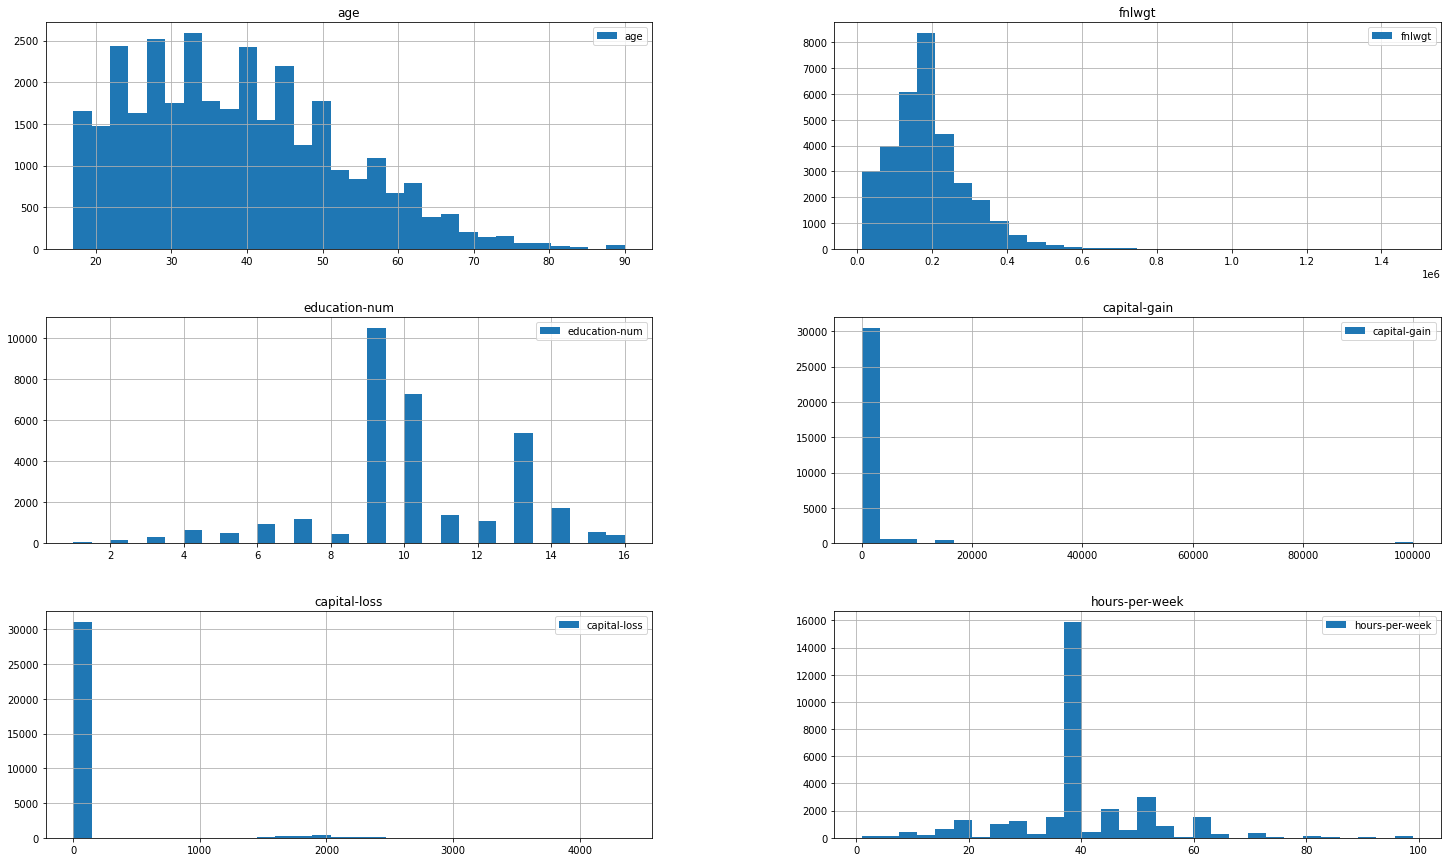

In [16]:
histogram = adult_data_df.hist(bins=30, figsize=(25, 15), grid=True, legend=True)

In [17]:
for n in columns_cat:
    print(n, adult_data_df[n].unique(), "\n")

workclass [' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked'] 

education [' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th'] 

marital-status [' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed'] 

occupation [' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' ' ?'
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv'] 

relationship [' Not-in-family' ' Husband' ' Wife' ' Own-child' ' Unmarried'
 ' Other-relative'] 

race [' White' ' Black' ' Asian-Pac-Islander' ' Amer-Indian-Eskimo' ' Other'] 

sex [' Male' ' Female'] 

native-country [' United-States' ' Cuba' ' Jamai

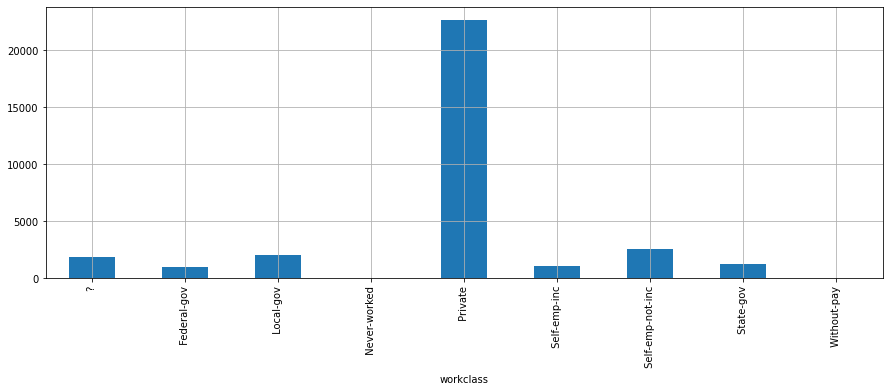

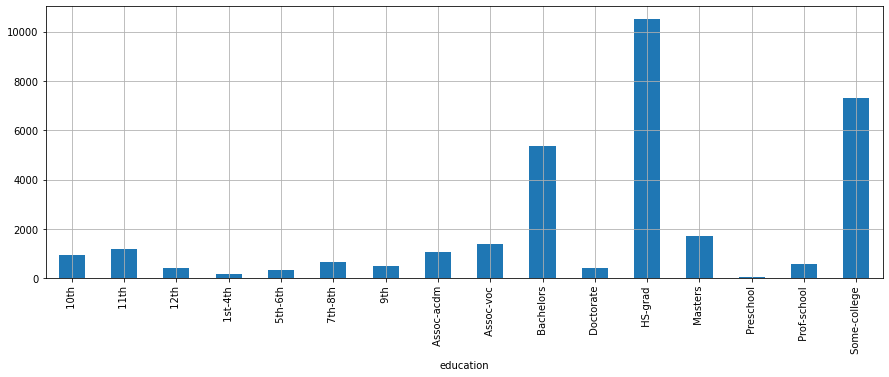

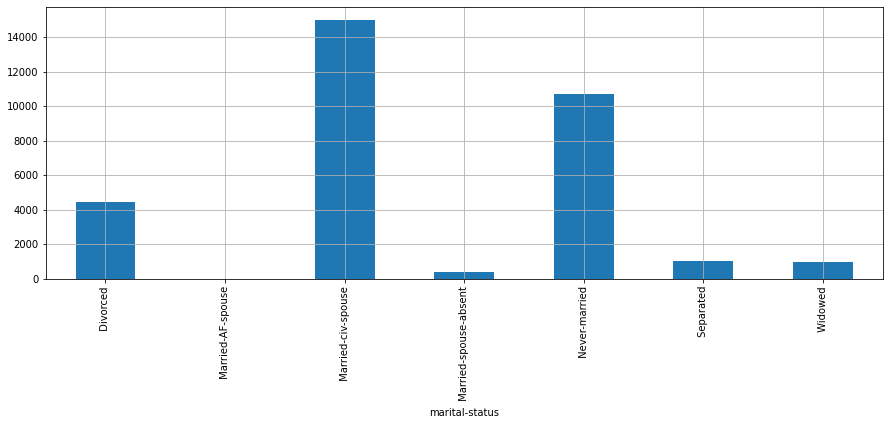

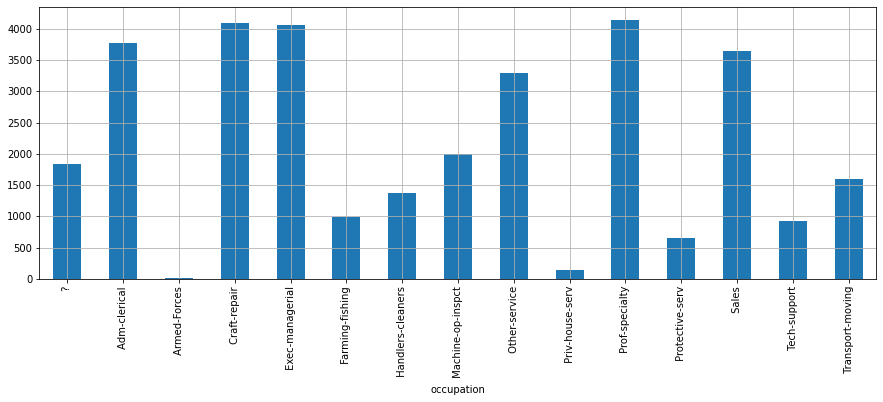

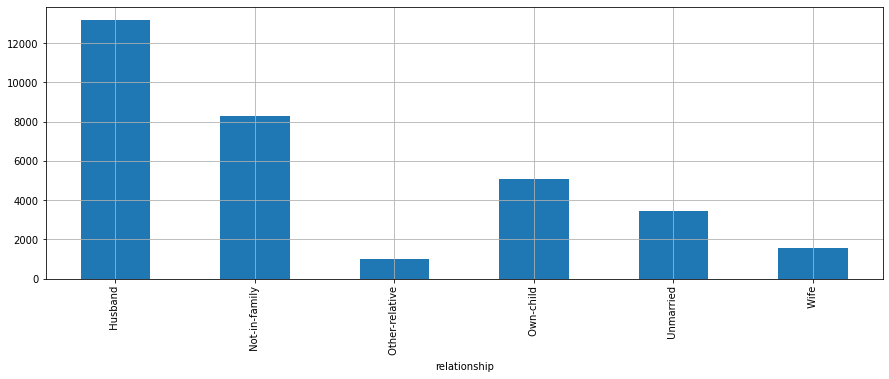

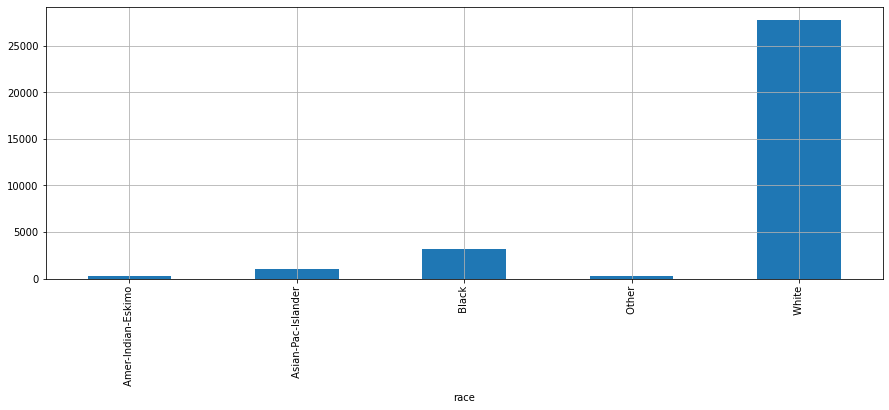

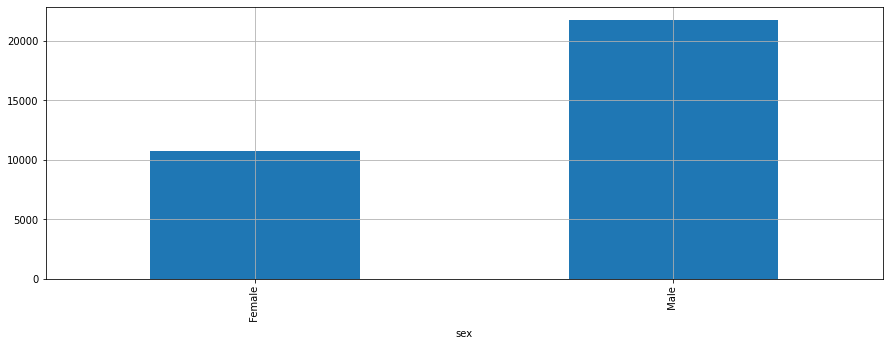

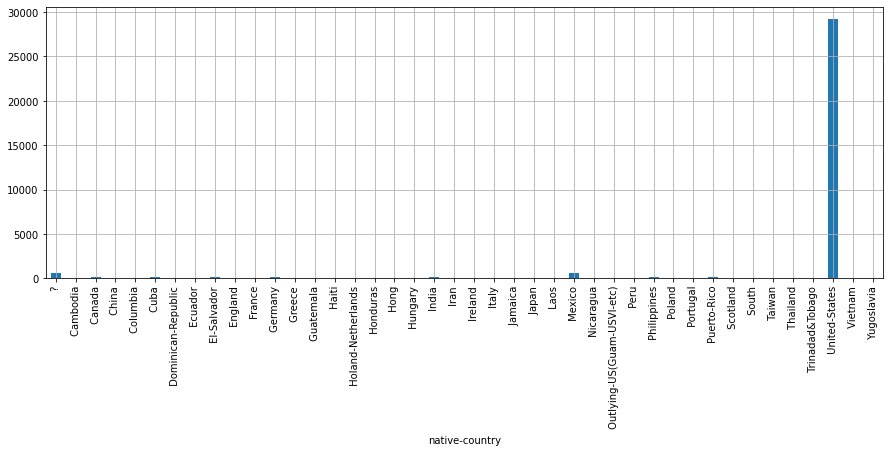

In [18]:
for i, col_name in enumerate(columns_cat):
    fig, ax = plt.subplots(figsize=(5,5))
    bar = adult_data_df.groupby(col_name).size().plot(kind='bar', ax=ax, figsize=(15, 5), grid=True)

In [19]:
sex_one_hot = OneHotEncoder().fit_transform(adult_data_df[['sex']])
sex_one_hot.toarray()

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [20]:
for c in columns_cat:
    print(c, adult_data_df[c].unique(), '\n')

workclass [' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked'] 

education [' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th'] 

marital-status [' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed'] 

occupation [' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' ' ?'
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv'] 

relationship [' Not-in-family' ' Husband' ' Wife' ' Own-child' ' Unmarried'
 ' Other-relative'] 

race [' White' ' Black' ' Asian-Pac-Islander' ' Amer-Indian-Eskimo' ' Other'] 

sex [' Male' ' Female'] 

native-country [' United-States' ' Cuba' ' Jamai

In [21]:
workclass_enc = LabelEncoder()
work_tr = workclass_enc.fit_transform(adult_data_df['workclass'])
# print(type(work_tr))
# min(work_tr), max(work_tr)
# dict(zip(workclass.classes_, workclass.transform(workclass.classes_)))
np.c_[workclass_enc.classes_, workclass_enc.transform(workclass_enc.classes_)]


array([[' ?', 0],
       [' Federal-gov', 1],
       [' Local-gov', 2],
       [' Never-worked', 3],
       [' Private', 4],
       [' Self-emp-inc', 5],
       [' Self-emp-not-inc', 6],
       [' State-gov', 7],
       [' Without-pay', 8]], dtype=object)

In [22]:
df = pd.DataFrame()
df['class'] = LabelEncoder().fit_transform(adult_data_df['class'])
for c in columns_cat:
    df[c] = LabelEncoder().fit_transform(adult_data_df[c])
df.corr()

,class,workclass,education,marital-status,occupation,relationship,race,sex,native-country
class,1.000000,0.051604,0.079317,-0.199307,0.075468,-0.250918,0.071846,0.215980,0.015840
workclass,0.051604,1.000000,0.023513,-0.064731,0.254892,-0.090461,0.049742,0.095981,-0.007690
education,0.079317,0.023513,1.000000,-0.038407,-0.021260,-0.010876,0.014131,-0.027356,0.064288
marital-status,-0.199307,-0.064731,-0.038407,1.000000,-0.009654,0.185451,-0.068013,-0.129314,-0.023819
occupation,0.075468,0.254892,-0.021260,-0.009654,1.000000,-0.075607,0.006763,0.080296,-0.012543
relationship,-0.250918,-0.090461,-0.010876,0.185451,-0.075607,1.000000,-0.116055,-0.582454,-0.005507
race,0.071846,0.049742,0.014131,-0.068013,0.006763,-0.116055,1.000000,0.087204,0.137852
sex,0.215980,0.095981,-0.027356,-0.129314,0.080296,-0.582454,0.087204,1.000000,-0.008119
native-country,0.015840,-0.007690,0.064288,-0.023819,-0.012543,-0.005507,0.137852,-0.008119,1.000000


<AxesSubplot:>

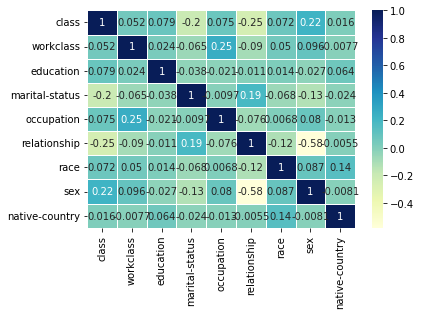

In [23]:
sb.heatmap(df.corr(), cmap="YlGnBu", annot=True, linewidths=1, )

In [24]:
print(adult_data_df['sex'], end='\n\n')
print(adult_data_df['sex'].shape, end='\n\n')
print(type(adult_data_df['sex']), end='\n\n')
print(adult_data_df[['sex']], end='\n\n')
print(adult_data_df[['sex']].shape, end='\n\n')
print(type(adult_data_df[['sex']]), end='\n\n')

0           Male
1           Male
2           Male
3           Male
4         Female
          ...   
32556     Female
32557       Male
32558     Female
32559       Male
32560     Female
Name: sex, Length: 32561, dtype: object

(32561,)

<class 'pandas.core.series.Series'>

           sex
0         Male
1         Male
2         Male
3         Male
4       Female
...        ...
32556   Female
32557     Male
32558   Female
32559     Male
32560   Female

[32561 rows x 1 columns]

(32561, 1)

<class 'pandas.core.frame.DataFrame'>



In [36]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(adult_data_df.drop('class', axis=1), adult_data_df['class'].copy())
train_set = X_train.join(y_train)
test_set = X_test.join(y_test)

# split = ShuffleSplit(test_size=0.25, random_state=42)
# train_index, test_index = list(split.split(adult_data_df[columns_num]))[0]

# for train_index, test_index in list(split.split(adult_data_df[columns_num])):
# train_set = adult_data_df.loc[train_index]
# test_set = adult_data_df.loc[test_index]
print(train_set.shape)
print(test_set.shape)
print(test_set.shape[0] / train_set.shape[0])

(24420, 15)
(8141, 15)
0.3333742833742834


In [37]:
X1 = train_set[columns_num].join(train_set[columns_cat])
X2 = train_set[columns_num].join(train_set[columns_corr_cat])
print(X1.shape, len(columns_num + columns_cat))
print(X2.shape, len(columns_num + columns_corr_cat))

(24420, 14) 14
(24420, 9) 9


In [38]:
from sklearn.preprocessing import Normalizer
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
])

sparse=True

ct1 = ColumnTransformer([
    ("norm2", Normalizer(norm='l2'), columns_num),
    ("onehot", OneHotEncoder(sparse=sparse), columns_cat)
])
ct2 = ColumnTransformer([
    ("norm2", Normalizer(norm='l2'), columns_num),
    ("onehot", OneHotEncoder(sparse=sparse), columns_corr_cat)
])
X1_prepared = ct1.fit_transform(X1)
X2_prepared = ct2.fit_transform(X2)


Y_prepared = LabelEncoder().fit_transform(train_set['class'].copy())

X1_test = ct1.fit_transform(test_set[columns_num].join(test_set[columns_cat]))
X2_test = ct2.fit_transform(test_set[columns_num].join(test_set[columns_corr_cat]))
Y_test = LabelEncoder().fit_transform(test_set['class'].copy()) # Y1, Y2 both are same

print(X1_prepared.shape)
print(X2_prepared.shape)
print(Y_prepared.shape)
print(X1_test.shape)
print(X2_test.shape)

(24420, 107)
(24420, 21)
(24420,)
(8141, 108)
(8141, 21)


In [30]:
def evaluate_model(model, X_prepared, Y_prepared, X_test, Y_test):
    print("**************************************")
    print(model)
    model.fit(X_prepared, Y_prepared)
#     predictions_ = model.predict(X_test)
#     mse_ = mean_squared_error(Y_test, predictions_)
#     print("mse on training set", mse_)

    predictions_ = model.predict(X_test)
    mse_ = mean_squared_error(Y_test, predictions_)
    print("mse on testing set", mse_)

    print("neg_mean_squared_error")
    scores_ = cross_val_score(model, X_prepared, Y_prepared, scoring="neg_mean_squared_error", cv=10)
    rmse_scores_ = np.sqrt(-scores_)
    display_scores(rmse_scores_)

    print("accuracy")
    scores_ = cross_val_score(model, X_prepared, Y_prepared, scoring="accuracy", cv=10)
    rmse_scores_ = np.sqrt(scores_)
    display_scores(rmse_scores_)

In [31]:
evaluate_model(SGDClassifier(), X2_prepared, Y_prepared, X2_test, Y_test)

**************************************
SGDClassifier()
mse on testing set 0.21926053310404128
neg_mean_squared_error
Scores: [0.47111487 0.47154928 0.47501024 0.4689368  0.47414737 0.47111487
 0.47501024 0.47673129 0.46499055 0.46849997]
Mean: 0.4717105476719744
Standard deviation: 0.003417855691597223
accuracy
Scores: [0.88276796 0.88114288 0.88091048 0.88137522 0.88276796 0.88207187
 0.87835003 0.87904907 0.88600919 0.8892386 ]
Mean: 0.8823683269753431
Standard deviation: 0.0030437039709432755
